In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
incidents = pd.read_csv('../data/sit_209/preprocessed/incidents.csv', index_col=0)
print(f"Incidents shape: {incidents.shape}")
reports = pd.read_csv('../data/sit_209/preprocessed/reports.csv')
print(f"Reports shape: {reports.shape}")
resources = pd.read_csv('../data/sit_209/preprocessed/resources.csv', index_col=0)
print(f"Resources shape: {resources.shape}")
plt.style.use('../fire_style.mplstyle')

Incidents shape: (94099, 31)
Reports shape: (45389, 21)


C:\Users\benja\AppData\Local\Temp\ipykernel_80724\244539117.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  reports = pd.read_csv('../data/sit_209/preprocessed/reports.csv')


Resources shape: (480143, 6)


## Merge study

In [3]:
df = incidents.merge(reports, left_on="INCIDENT_IDENTIFIER", right_on="INC_IDENTIFIER")

In [58]:
from_date.min()
to_date

1352984400000000000

In [62]:
df['REPORT_TO_DATE'].isna().sum()

200

In [59]:
pd.to_datetime(1352984400000000000)

Timestamp('2012-11-15 13:00:00')

In [54]:
pd.to_datetime((from_date + to_date)/2).year.value_counts()

2017    13014
2015    11198
2018    10848
2016    10008
1846      152
1847       48
2014       35
2012        1
Name: count, dtype: int64

In [64]:
df = incidents.merge(reports, left_on="INCIDENT_IDENTIFIER", right_on="INC_IDENTIFIER")
df['REPORT_TO_DATE'].fillna(df['REPORT_FROM_DATE'], inplace=True)
from_date = pd.to_datetime(df['REPORT_FROM_DATE']).values.astype('int64')
to_date = pd.to_datetime(df['REPORT_TO_DATE']).values.astype('int64')
pd.to_datetime((from_date + to_date)/2).year.value_counts()

2017    13022
2015    11344
2018    10848
2016    10054
2014       35
2012        1
Name: count, dtype: int64

In [94]:
def preprocess(df, features=None, target_transform=None):
  #target engineering


  df['next_incident_area'] = df.groupby('INCIDENT_IDENTIFIER')['CURR_INCIDENT_AREA'].shift(-1)

  df = df[df['next_incident_area'].notna()]

  if target_transform=='sqrt':
    df['incident_area'] = np.sqrt(df['CURR_INCIDENT_AREA'])
    df['next_incident_area'] = np.sqrt(df['next_incident_area'])

  elif target_transform=='log':
    df['incident_area'] = np.log(1+df['CURR_INCIDENT_AREA'])
    df['next_incident_area'] = np.log(1+df['next_incident_area'])
  else:
    df['incident_area'] = df['CURR_INCIDENT_AREA']

  # feature selection
  df = df[features+['next_incident_area']]

  #encoding + scaling
  le = LabelEncoder()
  df['cause_id'] = df['cause_id'].astype('int')
  cat_cols = ['cause_id', 'STATUS', 'year', 'month']


  #le = LabelEncoder()
  #for col in cat_cols:
  #    df[col] = le.fit_transform(df[col])
  df = pd.get_dummies(df, columns=cat_cols)
  print(df.columns)
  scaler = StandardScaler()
  numerical_cols = [col for col in df.columns if col not in cat_cols+['INCIDENT_IDENTIFIER']]
  df.loc[:, numerical_cols] = scaler.fit_transform(df[numerical_cols])
  return df
df = incidents.merge(reports, left_on="INCIDENT_IDENTIFIER", right_on="INC_IDENTIFIER")
df = preprocess(df, features=['INCIDENT_IDENTIFIER', 'cause_id', 'STATUS', 'year', 'month', 'incident_area'])
df.describe()

Index(['INCIDENT_IDENTIFIER', 'incident_area', 'next_incident_area',
       'cause_id_1', 'cause_id_2', 'cause_id_3', 'cause_id_4', 'STATUS_F',
       'STATUS_I', 'STATUS_U', 'year_2012', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'year_2018', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')


C:\Users\benja\AppData\Local\Temp\ipykernel_80724\363256067.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['incident_area'] = df['CURR_INCIDENT_AREA']


,INCIDENT_IDENTIFIER,incident_area,next_incident_area,cause_id_1,cause_id_2,cause_id_3,cause_id_4,STATUS_F,STATUS_I,STATUS_U,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,3.751200e+04,3.751100e+04,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,...,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,37512.000000,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04,3.751200e+04
mean,6.055369e+06,-5.303830e-18,4.546019e-18,8.485902e-17,-9.016271e-17,-2.746553e-17,1.227425e-16,7.879766e-17,1.121351e-16,-1.333499e-16,...,7.425164e-17,-9.092038e-18,3.636815e-17,-4.242951e-17,0.000000,6.515960e-17,-6.364426e-17,1.515340e-18,-3.030679e-18,-2.576077e-17
std,2.435626e+06,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,2.714022e+06,-5.833179e-02,-5.867252e-02,-1.001227e+00,-5.910194e-01,-9.620433e-02,-5.486020e-01,-1.324784e-01,-4.237754e-01,-2.213587e+00,...,-2.045149e-01,-1.992224e-01,-1.888674e-01,-3.384344e-01,-0.492683,-6.063855e-01,-4.724448e-01,-2.396262e-01,-2.087927e-01,-1.100659e-01
25%,4.256244e+06,-5.813862e-02,-5.845270e-02,-1.001227e+00,-5.910194e-01,-9.620433e-02,-5.486020e-01,-1.324784e-01,-4.237754e-01,4.517554e-01,...,-2.045149e-01,-1.992224e-01,-1.888674e-01,-3.384344e-01,-0.492683,-6.063855e-01,-4.724448e-01,-2.396262e-01,-2.087927e-01,-1.100659e-01
50%,7.172960e+06,-5.729975e-02,-5.747175e-02,9.987745e-01,-5.910194e-01,-9.620433e-02,-5.486020e-01,-1.324784e-01,-4.237754e-01,4.517554e-01,...,-2.045149e-01,-1.992224e-01,-1.888674e-01,-3.384344e-01,-0.492683,-6.063855e-01,-4.724448e-01,-2.396262e-01,-2.087927e-01,-1.100659e-01
75%,7.419286e+06,-5.159330e-02,-5.150578e-02,9.987745e-01,1.691992e+00,-9.620433e-02,-5.486020e-01,-1.324784e-01,-4.237754e-01,4.517554e-01,...,-2.045149e-01,-1.992224e-01,-1.888674e-01,-3.384344e-01,-0.492683,1.649116e+00,-4.724448e-01,-2.396262e-01,-2.087927e-01,-1.100659e-01
max,9.276448e+06,2.193709e+01,2.193722e+01,9.987745e-01,1.691992e+00,1.039454e+01,1.822815e+00,7.548401e+00,2.359741e+00,4.517554e-01,...,4.889618e+00,5.019515e+00,5.294720e+00,2.954782e+00,2.029703,1.649116e+00,2.116649e+00,4.173166e+00,4.789440e+00,9.085464e+00


In [113]:

train_pct = 0.8
train_len = int(train_pct*len(unique_ids))
train_mask = np.zeros(len(unique_ids), dtype=int)
train_mask[:train_len] = 1
np.random.shuffle(a)

In [116]:
unique_ids = df['INCIDENT_IDENTIFIER'].unique()
train_ids, valid_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = df[df['INCIDENT_IDENTIFIER'].isin(train_ids)]
valid_df = df[df['INCIDENT_IDENTIFIER'].isin(valid_ids)]

,INCIDENT_IDENTIFIER,incident_area,next_incident_area,cause_id_1,cause_id_2,cause_id_3,cause_id_4,STATUS_F,STATUS_I,STATUS_U,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
415,2714022,-0.058249,-0.058521,-1.001227,-0.591019,-0.096204,1.822815,-0.132478,2.359741,-2.213587,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
414,2714022,-0.058181,-0.058521,-1.001227,-0.591019,-0.096204,1.822815,-0.132478,-0.423775,0.451755,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
416,2714022,-0.058181,-0.058521,-1.001227,-0.591019,-0.096204,1.822815,-0.132478,-0.423775,0.451755,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
419,2714081,-0.058219,-0.058560,-1.001227,1.691992,-0.096204,-0.548602,-0.132478,2.359741,-2.213587,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
418,2714081,-0.058219,-0.058559,-1.001227,1.691992,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43988,9276339,-0.058277,-0.058618,-1.001227,1.691992,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
43991,9276448,-0.058066,-0.056836,0.998774,-0.591019,-0.096204,-0.548602,-0.132478,2.359741,-2.213587,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
43990,9276448,-0.056496,-0.056798,0.998774,-0.591019,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
43993,9276448,-0.056457,-0.056799,0.998774,-0.591019,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066


In [109]:
train = df[df['INCIDENT_IDENTIFIER'].isin(unique_ids[select_mask])]

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [106]:
train.shape

(30193, 28)

(37512, 28)

<Axes: >

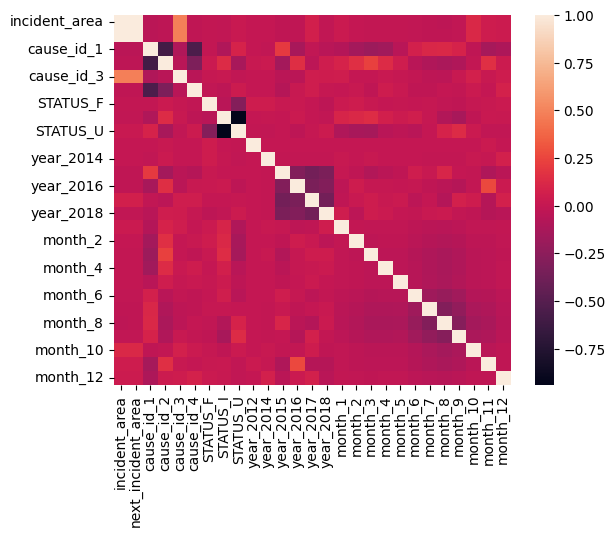

In [77]:
import seaborn as sns
sns.heatmap(df.corr())

In [80]:
# Import the necessary module
from sklearn.model_selection import train_test_split

# Assume X and y are defined somewhere above this
# X is your features and y is your target

# Split the data into training and testing sets

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


linear_regression_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor()
random_forest_model = RandomForestRegressor()
svr_model = SVR()

In [91]:
df

,incident_area,next_incident_area,cause_id_1,cause_id_2,cause_id_3,cause_id_4,STATUS_F,STATUS_I,STATUS_U,year_2012,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
415,-0.058249,-0.058521,-1.001227,-0.591019,-0.096204,1.822815,-0.132478,2.359741,-2.213587,-0.005163,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
414,-0.058181,-0.058521,-1.001227,-0.591019,-0.096204,1.822815,-0.132478,-0.423775,0.451755,-0.005163,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
416,-0.058181,-0.058521,-1.001227,-0.591019,-0.096204,1.822815,-0.132478,-0.423775,0.451755,-0.005163,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
419,-0.058219,-0.058560,-1.001227,1.691992,-0.096204,-0.548602,-0.132478,2.359741,-2.213587,-0.005163,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
418,-0.058219,-0.058559,-1.001227,1.691992,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,-0.005163,...,-0.204515,-0.199222,5.294720,-0.338434,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43988,-0.058277,-0.058618,-1.001227,1.691992,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,-0.005163,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
43991,-0.058066,-0.056836,0.998774,-0.591019,-0.096204,-0.548602,-0.132478,2.359741,-2.213587,-0.005163,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
43990,-0.056496,-0.056798,0.998774,-0.591019,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,-0.005163,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066
43993,-0.056457,-0.056799,0.998774,-0.591019,-0.096204,-0.548602,-0.132478,-0.423775,0.451755,-0.005163,...,-0.204515,-0.199222,-0.188867,2.954782,-0.492683,-0.606385,-0.472445,-0.239626,-0.208793,-0.110066


In [88]:
X_train, X_test, y_train, y_test = train_test_split(df_lin.drop('next_incident_area', axis=1), df_lin['next_incident_area'], test_size=0.2, random_state=42)
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [89]:
y_pred_lr = linear_regression_model.predict(X_test)

Intercept:  4.831884849007453e-05
Coefficients:  [ 9.99725753e-01 -1.13195736e+10 -9.91636165e+09 -2.15801266e+09
 -9.54668167e+09 -4.11195867e+09 -1.13466054e+10 -1.18496808e+10
  1.69077327e+07  5.60691304e+07  1.40694697e+09  1.34557200e+09
  1.49021919e+09  1.41323269e+09 -3.21437795e+09 -5.14014640e+09
 -6.95888024e+09 -6.79272779e+09 -6.46464852e+09 -1.07643877e+10
 -1.40539409e+10 -1.57168874e+10 -1.36918399e+10 -8.03334012e+09
 -7.09239933e+09 -3.85507555e+09]
R2:  0.999769559287043


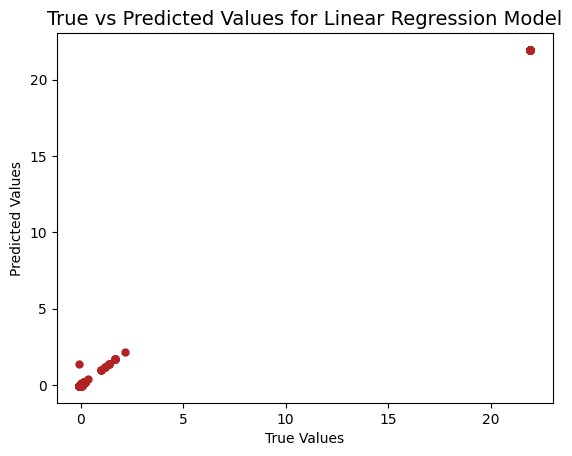

In [90]:
# Import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

linear_regression_model.fit(X_train, y_train)

print("Intercept: ", linear_regression_model.intercept_)
print("Coefficients: ", linear_regression_model.coef_)

# Predict the target variable on the testing data
y_pred = linear_regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

plt.scatter(y_test, y_pred)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()

In [ ]:
df = preprocessed_df[[col for col in preprocessed_df.columns if col != 'PROJ_INCIDENT_AREA']]
df = df[df[['CURR_INCIDENT_AREA','PCT_CONTAINED_COMPLETED_y', 'NEXT_DAY_CURR_INCIDENT_AREA']].notna().all(axis=1)]
X = df.drop(columns=['NEXT_DAY_CURR_INCIDENT_AREA'])
y= df['NEXT_DAY_CURR_INCIDENT_AREA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=209)


LinearRegression()

In [ ]:

from sklearn.metrics import mean_squared_error
y_pred_lr = linear_regression_model.predict(X_test)
print("Linear Regression MSE: ", mean_squared_error(y_test, y_pred_lr))

Linear Regression MSE:  0.058324091019538025


Intercept:  0.08426457802379983
Coefficients:  [-4.89795005e-02  5.63929445e-04  9.86115467e-01 -3.78074919e-02]
R2:  0.943092478081508


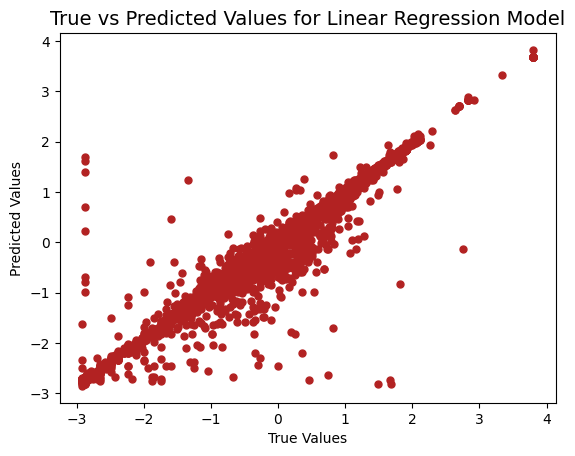

In [ ]:
# Import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

linear_regression_model.fit(X_train, y_train)

print("Intercept: ", linear_regression_model.intercept_)
print("Coefficients: ", linear_regression_model.coef_)

# Predict the target variable on the testing data
y_pred = linear_regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

plt.scatter(y_test, y_pred)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()


In [ ]:
X_train

,INCIDENT_IDENTIFIER,INC209R_IDENTIFIER,STATUS,CAUSE_IDENTIFIER,CURR_INCIDENT_AREA,PCT_CONTAINED_COMPLETED_y
40002,1.248276,1.248131,1,13,-1.071536,-1.223145
201,-1.371382,-1.371531,2,1,0.444507,-1.223145
41279,1.275079,1.275056,2,13,1.735516,0.858827
38459,1.268385,1.268398,2,13,1.290626,0.468457
14439,-0.714185,-0.714231,2,4,0.925885,0.130136
...,...,...,...,...,...,...
20538,-0.669934,-0.670001,2,4,-0.167028,0.624605
293,-1.369654,-1.369795,2,1,1.535377,-1.223145
10355,-1.296979,-1.297107,2,1,-0.812935,-0.702652
25336,0.484003,0.484060,2,11,-1.155953,-1.223145


In [ ]:
import statsmodels.api as sm
from scipy import stats

                                 OLS Regression Results                                
Dep. Variable:     NEXT_DAY_CURR_INCIDENT_AREA   R-squared:                       0.957
Model:                                     OLS   Adj. R-squared:                  0.957
Method:                          Least Squares   F-statistic:                 1.653e+05
Date:                         Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                                 15:52:36   Log-Likelihood:                 4588.2
No. Observations:                        29990   AIC:                            -9166.
Df Residuals:                            29985   BIC:                            -9125.
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [ ]:
le = LabelEncoder()
scaler = StandardScaler()

def preprocess_df(df):
    preprocessed_df = df.iloc[:, :].copy()
    #preprocess_df['year'] = preprocess_df['REPORT_FROM_DATE'].dt.year
    #preprocess_df['month'] = preprocess_df['REPORT_FROM_DATE'].dt.month
    cat_cols = ['CAUSE_IDENTIFIER', 'STATUS']#, 'year', 'month']
    preprocessed_df = pd.get_dummies(preprocessed_df, columns=cat_cols)
    print(preprocessed_df.columns)
    #for col in cat_cols:
     #   preprocessed_df[col] = le.fit_transform(preprocessed_df[col])

    preprocessed_df = preprocessed_df.drop(columns=["REPORT_FROM_DATE", "REPORT_TO_DATE" , "INCIDENT_IDENTIFIER", "INC209R_IDENTIFIER"])
    numerical_cols = [col for col in preprocessed_df.columns if col not in cat_cols]
    preprocessed_df[numerical_cols] = scaler.fit_transform(preprocessed_df[numerical_cols])
    return preprocessed_df


preprocessed_df = preprocess_df(df_next_day)
df = preprocessed_df[[col for col in preprocessed_df.columns if col != 'PROJ_INCIDENT_AREA']]
df = df[df[['CURR_INCIDENT_AREA','PCT_CONTAINED_COMPLETED_y', 'NEXT_DAY_CURR_INCIDENT_AREA']].notna().all(axis=1)]
X = df.drop(columns=['NEXT_DAY_CURR_INCIDENT_AREA'])
y= df['NEXT_DAY_CURR_INCIDENT_AREA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=209)

Index(['INCIDENT_IDENTIFIER', 'INC209R_IDENTIFIER', 'REPORT_FROM_DATE',
       'REPORT_TO_DATE', 'CURR_INCIDENT_AREA', 'PROJ_INCIDENT_AREA',
       'PCT_CONTAINED_COMPLETED_y', 'NEXT_DAY_CURR_INCIDENT_AREA',
       'CAUSE_IDENTIFIER_1536117.0', 'CAUSE_IDENTIFIER_1536118.0',
       'CAUSE_IDENTIFIER_1536119.0', 'CAUSE_IDENTIFIER_1536120.0',
       'CAUSE_IDENTIFIER_2990063.0', 'CAUSE_IDENTIFIER_2990064.0',
       'CAUSE_IDENTIFIER_2990065.0', 'CAUSE_IDENTIFIER_2990066.0',
       'CAUSE_IDENTIFIER_4496045.0', 'CAUSE_IDENTIFIER_4496046.0',
       'CAUSE_IDENTIFIER_4496047.0', 'CAUSE_IDENTIFIER_4496048.0',
       'CAUSE_IDENTIFIER_7483985.0', 'CAUSE_IDENTIFIER_7483986.0',
       'CAUSE_IDENTIFIER_7483987.0', 'CAUSE_IDENTIFIER_7483988.0', 'STATUS_F',
       'STATUS_I', 'STATUS_U'],
      dtype='object')


In [ ]:
linear_regression_model.fit(X_train, y_train)
y_pred_lr = linear_regression_model.predict(X_test)
print("Linear Regression MSE: ", mean_squared_error(y_test, y_pred_lr))

Linear Regression MSE:  0.058132097507936104


Intercept:  -0.0002523897534943099
Coefficients:  [ 9.87403132e-01 -3.51332942e-02 -4.50752198e+11 -8.96343832e+11
 -3.97199013e+10 -4.89004430e+11 -6.53908320e+11 -6.70794456e+11
 -1.25620427e+10 -5.31661634e+11 -6.27961267e+11 -8.54368530e+11
 -1.54056017e+11 -6.55127740e+11 -6.33523681e+11 -7.66476404e+11
 -1.69061857e+11 -5.78691515e+11 -1.45013791e+10 -4.14605270e+10
 -4.31746617e+10]
R2:  0.9432798084758391


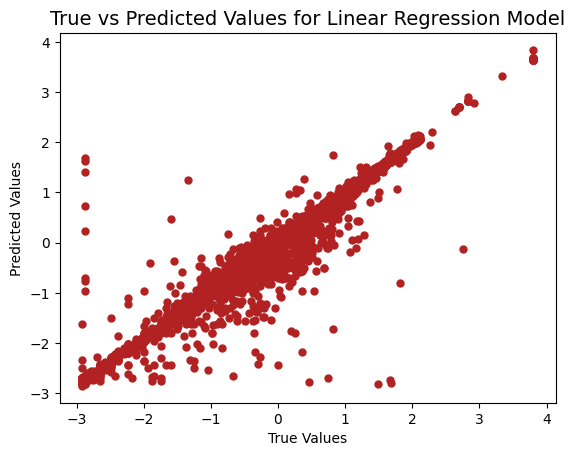

In [ ]:
print("Intercept: ", linear_regression_model.intercept_)
print("Coefficients: ", linear_regression_model.coef_)

# Predict the target variable on the testing data
y_pred = linear_regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

plt.scatter(y_test, y_pred)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values for Linear Regression Model')
plt.show()

In [ ]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:     NEXT_DAY_CURR_INCIDENT_AREA   R-squared:                       0.957
Model:                                     OLS   Adj. R-squared:                  0.957
Method:                          Least Squares   F-statistic:                 3.162e+04
Date:                         Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                                 14:59:09   Log-Likelihood:                 4657.5
No. Observations:                        29990   AIC:                            -9271.
Df Residuals:                            29968   BIC:                            -9088.
Df Model:                                   21                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [ ]:
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)

y_pred_dt = decision_tree_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)
y_pred_svr = svr_model.predict(X_test)

from sklearn.metrics import mean_squared_error

print("Linear Regression MSE: ", mean_squared_error(y_test, y_pred_lr))
print("Decision Tree MSE: ", mean_squared_error(y_test, y_pred_dt))
print("Random Forest MSE: ", mean_squared_error(y_test, y_pred_rf))
print("SVR MSE: ", mean_squared_error(y_test, y_pred_svr))

Linear Regression MSE:  0.08627282871466105
Decision Tree MSE:  0.11954987792870217
Random Forest MSE:  0.09496982802322926
SVR MSE:  0.0894830984045423


## Adding treatment

In [ ]:
pivot_df = pd.pivot_table(resources,
                          values=['RESOURCE_QUANTITY', 'RESOURCE_PERSONNEL'],
                          index=['INC209R_IDENTIFIER'],
                          columns=['resource'],
                          aggfunc='sum',
                          fill_value=0)

# Flatten the multi-level column index
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset index to make it look like a regular DataFrame
pivot_df.reset_index(inplace=True)

In [ ]:
personnel = resources.groupby("INC209R_IDENTIFIER")["RESOURCE_PERSONNEL"].sum().to_frame().reset_index()


In [ ]:
df = df_next_day.merge(personnel, on='INC209R_IDENTIFIER', how='left')

,INCIDENT_IDENTIFIER,INC209R_IDENTIFIER,REPORT_FROM_DATE,REPORT_TO_DATE,STATUS,CAUSE_IDENTIFIER,CURR_INCIDENT_AREA,PROJ_INCIDENT_AREA,PCT_CONTAINED_COMPLETED_y,NEXT_DAY_CURR_INCIDENT_AREA,RESOURCE_PERSONNEL
0,2714022,2714023,2015-05-05 09:30:00,2015-05-07 11:00:00,I,1536120.0,5.017280,NaN,90.0,5.620401,45.0
1,2714022,2714037,2015-05-07 11:00:00,2015-05-08 14:00:00,U,1536120.0,5.620401,NaN,100.0,5.620401,45.0
2,2714022,2714050,2015-05-08 11:00:00,2015-05-09 14:00:00,U,1536120.0,5.620401,275.0,100.0,5.620401,33.0
3,2714081,2714082,2015-05-06 20:30:00,2015-05-07 18:00:00,I,1536117.0,5.327876,220.0,60.0,5.327876,21.0
4,2714081,2714097,2015-05-07 18:15:00,2015-05-08 14:00:00,U,1536117.0,5.327876,220.0,60.0,5.332719,15.0
...,...,...,...,...,...,...,...,...,...,...,...
37507,9276339,9276401,2018-06-12 16:00:00,2018-06-13 15:00:00,U,7483985.0,4.615121,NaN,71.0,4.615121,109.0
37508,9276448,9276458,2018-06-10 01:00:00,2018-06-14 18:15:00,I,7483986.0,6.184149,NaN,0.0,8.114325,NaN
37509,9276448,9276449,2018-06-14 21:45:00,2018-06-21 21:45:00,U,7483986.0,8.114325,NaN,0.0,8.135054,NaN
37510,9276448,9276476,2018-06-21 21:45:00,2018-06-28 22:45:00,U,7483986.0,8.135054,3500.0,0.0,8.134761,NaN
